# Experiments Pertaining to 

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path
from collections import OrderedDict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
#import missingno as mso
#import pandas_profiling as pdp

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from torchvision import models
import torchvision.transforms as T
#from torchvision.utils import make_grid
#from efficientnet_pytorch import EfficientNet
#import torchsummary
# local files
from plotting import show_batch, plot_learning_curves
from modeling import CheXModel
from dataaug import TemplateCrop

C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Globals

In [3]:
USE_CUDA = False#True
ON_AWS = False#True
NUM_WORKERS = 4 if ON_AWS else 0 
DEVICE = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')

In [4]:
SEED = 404
def seed_everything(seed=SEED, env=None):
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [5]:
PATH_DATA = Path('data/')
chxpath = PATH_DATA/'CheXpert-v1.0-small/'
path_train = chxpath/'train'
path_valid = chxpath/'valid'
PATH_PART = Path('partion_sample/partition_data')


In [37]:
TARGET_LABELS = ['No_Finding', 'Enlarged_Cardiomediastinum', 'Cardiomegaly',
       'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other',
       'Fracture', 'Support_Devices']
TARGET5_LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
TARGET5_INDEX = [TARGET_LABELS.index(t5) for t5 in TARGET5_LABELS]

## Data

In [7]:
df_train = pd.read_csv(chxpath/'train.csv')
df_valid = pd.read_csv(chxpath/'valid.csv')

In [8]:
def label_smooth(df, method='uones', smooth_bounds=None):
    df_sub = df.copy()
    if smooth_bounds is None:
        eps = 1e-5
        if method == 'uones':
            smooth_bounds = (0.55, 0.85+eps)
        elif method=='uzeros':
            smooth_bounds = (0, 0.30+eps)
        else:
            smooth_bounds = (0, 0.85+eps)
    
    if method in ['uones','uzeros']:
        smooth_distrb = np.random.uniform(*smooth_bounds,df_sub[TARGET_LABELS].shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_sub[TARGET_LABELS]==-1, smooth_distrb, df_sub[TARGET_LABELS])
        
    return df_sub

def proc_df(df, method='uones', smooth=True, nafill_val=0, ufill_val=1, **kwargs):
    """
    Preprocess dataframe for model consumption
    
    Args:
        df (pandas.DataFrame): dataframe containing img paths, metadata, and labels.
        method (str), ('uzeros','uones','constant'): method for replacing uncertainty labels (default: 'uones')
        smooth (bool): use Label Smoothing Regression (LSR) only applies when `method`=('uzeros','uones') (default: True) 
        nafill_val (int,float): value used to fill nan values (default: 0)
        ufill_val (int,float): value used to fill -1 (uncertainty) labels
    
    kwargs:
        smooth_bounds (tuple(float,float)): replace -1 labels uniform random values between the given bounds
        (default: `method`='uzeros': (0,0.3001), `method`='uones': (0.55,0.8501) when `Smooth`=True, 
                
    Returns:
        processed_df: pandas.Dataframe
    """
    
    is_val = df['Path'].str.contains('valid').all()
    df_sub = df.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'],errors='ignore')
    
    if is_val:
        return df_sub # val set has no nans, no -1s
    
    df_targets = df_sub[TARGET_LABELS]
    
    if isinstance(nafill_val,tuple):
        nan_smooth_distrb = np.random.uniform(*nafill_val, df_targets.shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_targets.isna(), nan_smooth_distrb, df_targets)
    else:
        df_sub = df_sub.fillna(nafill_val)
    
    if smooth:
        df_sub = label_smooth(df_sub, method, kwargs.get('smooth_bounds'))
    elif method == 'constant':
        df_sub = df_sub.replace(-1,ufill_val)
    elif method in ['uzeros','uones'] and ufill_val not in [0.0,1.0]:
        print(f'WARNING: Overwritting `ufill_val` to match method "{method}"')
        ufill_val = 1.0 if method=='uones' else 0.0
        df_sub = df_sub.replace(-1,ufill_val)
    
    df_sub.loc[:,TARGET_LABELS] = df_sub.loc[:,TARGET_LABELS].astype(float)
    
    return df_sub

### Preprocessing

In [23]:
df_master = pd.read_csv(PATH_PART/'CheX_Full_02.csv')
df_sampb2 = pd.read_csv(PATH_PART/'CheX_Sample_B2.csv')

In [24]:
def make_df_merged(df_master):
    # Filter out undesirable data entries
    data_tot = df_master[#(df_master.Dataset_ID ==1) &
                          (df_master.gender != 'U') 
                         & df_master.ap_pa_ll.isin(['AP','LL','PA']) 
                         & df_master[TARGET_LABELS].notna().any(axis=1)].reset_index(drop=True)

    # Count each quanity of nan, -1, 0, and 1 labels per sample
    count_mat = np.vstack((np.isnan(data_tot[TARGET_LABELS].values).sum(1),
                           (data_tot[TARGET_LABELS].values == -1).sum(1),
                           (data_tot[TARGET_LABELS].values == 0).sum(1),
                           (data_tot[TARGET_LABELS].values == 1).sum(1))).T

    # Create an equal-index dataframe
    df_counts = pd.DataFrame(count_mat,index=data_tot.index, columns=['n_nan','n_unk','n_neg','n_pos'])
    df_totcnts = pd.concat([data_tot[['patient_id','study','CheX_Image_ID']],df_counts],axis=1)
    
    # Assign patient-study group id (Option 1 BROKEN)
    #psid = df_totcnts['patient_id'].astype(str).str.pad(7,'right','0').str.cat(df_totcnts['study'].astype(str)).astype(int)
    psid = df_totcnts.groupby(['patient_id','study']).ngroup() # (Option 2)
    df_totcnts.insert(2,'psid',psid)
    
    df_merged_all = data_tot.merge(df_totcnts)
    
    return df_merged_all.rename({'File_Path':'Path'},axis=1)

In [25]:
def quick_sample(df_merge, test_size=0.1, data_size=150000, use_allcols=False, seed=SEED):
    test_df = df_merge[df_merge['Dataset_ID'] == 2]
    df_merge = df_merge.drop(index=test_df.index)
    valid_df = df_merge[df_merge.n_unk.eq(0) & df_merge.n_nan.lt(14)].sample(frac=.1,random_state=seed)
    train_df = df_merge.drop(index=valid_df.index).sample(data_size-len(valid_df))
    
    tt_df = train_df.append(valid_df).append(test_df)
    tt_df.loc[train_df.index, 'data_id'] = 0
    tt_df.loc[valid_df.index, 'data_id'] = 1
    tt_df.loc[test_df.index, 'data_id'] = 2
    #if tt_df.index.isin(train_df.index) else (1 if tt_df.index.isin(valid_df.index) else 2)
    if use_allcols:
        return tt_df
    
    subcols = ['CheX_Image_ID','ap_pa_ll','data_id']
    return tt_df[subcols].assign(ap_pa_ll=tt_df['ap_pa_ll'].map({'AP':1,'PA':2,'LL':3})).astype(int)

## Image Augmentations

In [10]:
def advprop(image,**kwargs):
    return image*2.0-1.0
def get_transforms(varient='train', tfms_lib='albu', imgsize=(244,244)):
    if tfms_lib == 'albu':
        transform = A.Compose([
            A.RandomScale((-0.02,0.02)),
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0),A.RandomCrop(*imgsize, p=1.0)])
            ],p=1.0),
            A.CLAHE(p=0.5),
            A.HorizontalFlip(),
            A.Rotate((-7,7)),#,border_mode=cv2.BORDER_CONSTANT),
            A.IAAAffine(shear=(-5,5)),
            #A.Cutout(8,8,8),
            
            #A.Lambda(advprop),
            A.Normalize(),
            ToTensorV2(),
        ])
        
        tta_augments = A.Compose([
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0), A.CenterCrop(*imgsize,p=1.0)])
            ],p=1.0),
            A.OneOf([
                A.HorizontalFlip(),
                A.Rotate((-7,7)),#border_mode=cv2.BORDER_CONSTANT),
                A.IAAAffine(shear=(-5,5)),
                A.NoOp()
            ],p=1.0),
            A.Normalize(),
            ToTensorV2()
        ])
        
    elif tfms_lib == 'torch':
        transform = T.Compose([
            #T.RandomCrop(512,8,padding_mode='reflect') ,
            T.CenterCrop(imgsize),
            T.RandomHorizontalFlip(),
            T.RandomRotation(7),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            #T.RandomErasing(inplace=True)
        ])
        tta_augments = T.Compose([T.CenterCrop(32),T.ToTensor()])
        
    return transform if varient == 'train' else tta_augments

## Dataset / DataLoader

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [12]:
# (blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive)
class CheXDataset(Dataset):
    def __init__(self, df, use_albu=True, tfms=None, smooth_bounds=None, seed=None, dpath=PATH_DATA):
        self.dfo = df
        self.df = df[['Path']+TARGET_LABELS]
        self.paths = self.df['Path'].values
        self.labels = self.df.drop(columns=['Path']).values.astype(float)
        #self.dpath = dpath
        self.tfms = tfms
        
        self.use_albu = use_albu
        self.smooth_bounds = smooth_bounds
        self._seedcntr=seed
        if self.tfms is not None:
            self.tfm_list = self.tfms.transforms.transforms if self.use_albu else self.tfms.transforms 
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        if self._seedcntr is not None:
            random.seed(self._seedcntr)
            self._seedcntr+=1
        labels = self.labels[idx]
        if self.smooth_bounds is not None:
            labels = np.where(labels==-1.,np.random.uniform(*self.smooth_bounds, size=len(labels)),labels)
        
        imgpath = str(PATH_DATA/self.paths[idx])
        
        is_lateral = 'lateral' in imgpath
        if self.use_albu:
            img = cv2.imread(imgpath)
            #img = template_match(img, template)
            #img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
            #img = np.expand_dims(cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE),2)
            aug = self.tfms(image=img, is_lateral=is_lateral)
            img = aug['image']
        else:
            img = Image.open(imgpath)
            img = self.tfms(img)
        
        return img,labels

In [13]:
# def get_dloaders(batch_size=32, sampsz=None, tfmlib='albu', seed=None, proc_kwargs=None):
#     if seed is not None:
#         seed_everything(seed)

#     if proc_kwargs is None:
#         proc_kwargs = dict(method='uones',smooth=True, nafill_val=0)
    
#     df_trn = proc_df(df_train, **proc_kwargs)
#     df_val = proc_df(df_valid)
#     if sampsz is not None:
#         df_trn = df_trn.sample(sampsz) #17->65k, 13->8k
    
#     ualbu = (tfmlib=='albu')
#     train_tfm = get_transforms('train', tfmlib, (244,244))
#     valid_tfm = get_transforms('test', tfmlib, (244,244))

#     train_dataset = CheXDataset(df=df_trn, use_albu=ualbu, tfms=train_tfm, seed=seed)#smooth_bounds=(0.55,0.8501)
#     valid_dataset = CheXDataset(df=df_val, use_albu=ualbu, tfms=valid_tfm)

#     train_loader = DataLoader(train_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS)
#     valid_loader = DataLoader(valid_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=False)
    
#     return train_loader, valid_loader

In [14]:
# def subset_dloader(df, grp_id=None, is_train=False, grp_name='ap_pa_ll', batch_size=32, seed=None, tfmlib='albu', print_tfms=True):
#     if seed is not None:
#         seed_everything(seed)
    
#     set_tfms = get_transforms('train' if is_train else 'test', tfmlib, (244,244))
    
#     df_subset = df[df[grp_name].eq(grp_id)] if grp_id is not None else df

#     sub_dataset = CheXDataset(df=df_subset, use_albu=(tfmlib=='albu'), tfms=set_tfms, seed=seed)
#     sub_loader = DataLoader(sub_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=is_train)
    
#     if print_tfms:
#         print(f'{"="*20} Augmentations {"="*20}','\n'.join([*map(str, sub_loader.dataset.tfm_list)]),'-'*55,sep='\n')
    
#     return sub_loader

In [15]:
# def get_pdloaders(train_df, valid_df, grp_id, grp_name='ap_pa_ll', batch_size=32, seed=None, tfmlib='albu', print_tfms=True,):
#     if seed is not None:
#         seed_everything(seed)
    
    
    
#     ualbu = (tfmlib=='albu')
    
#     train_tfm = get_transforms('train', tfmlib, (244,244))
#     valid_tfm = get_transforms('test', tfmlib, (244,244))
    
#     df_trn = train_df[train_df[grp_name].eq(grp_id)]
#     df_val = valid_df[valid_df[grp_name].eq(grp_id)]
#     train_dataset = CheXDataset(df=df_trn, use_albu=ualbu, tfms=train_tfm, seed=seed)
#     valid_dataset = CheXDataset(df=df_val, use_albu=ualbu, tfms=valid_tfm, seed=seed)

#     train_loader = DataLoader(train_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS)
#     valid_loader = DataLoader(valid_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=False)
    

#     if print_tfms:
#         print(f'{"="*20} Augmentations {"="*20}','\n'.join([*map(str, train_loader.dataset.tfm_list)]),'-'*55,sep='\n')
    
#     return train_loader, valid_loader

## Model

### Model Helpers

In [16]:
@torch.no_grad()
def compute_auc(out,target):
    targ = target.round().detach().to('cpu')
    out = torch.sigmoid(out).detach().to('cpu')
    score = roc_auc_score(targ, out, average='micro',multi_class='ovo')

    return score

@torch.no_grad()
def compute_auc_dbg(out,target,ninv=0):
    try:
        targ = target.round().detach().to('cpu')
        out = torch.sigmoid(out).detach().to('cpu')#out.detach().to('cpu')#F.softmax(out,0).detach().to('cpu')
        #score = roc_auc_score(targ, out, multi_class='ovo')
        score = roc_auc_score(targ, out, average='micro',multi_class='ovo')
    except ValueError as e:
        score = 0.5
        ninv+=1
        #score = 0.5
    return score,ninv

In [17]:
def save_history(history, save_name, description, save_path='save/histories/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    desc = f'{save_name} - {description} \n'
    with full_path.joinpath('description.txt').open('a+') as f:
        f.write(desc)
    dump_path = full_path.joinpath(save_name).with_suffix('.pkl')    
    pickle.dump(history,dump_path.open('wb'))
    print('File saved to:',str(dump_path))

In [18]:
def save_trained(model, save_name, description=None, module='network', save_path='save/models/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    modelmod = getattr(model,module,model)
    states = OrderedDict(
        {n: c.state_dict() for n,c in modelmod.named_children() if any(p.requires_grad for p in c.parameters())}
    )
    if description is not None:
        desc = f"{save_name} - ({', '.join(states.keys())}) : {description} \n"
        with full_path.joinpath('description.txt').open('a+') as f:
            f.write(desc)
    
    out_path = full_path.joinpath(save_name).with_suffix('.pt')
    torch.save(states,out_path)
    
    print('state dict saved to:',out_path.as_posix())
    
def load_trained(model, save_name, module='network', save_path='save/models/'):
    """
    Example:
    model = CheXModel('densenet121')
    model = load_trained(model,'densenet121.pt')
    """
    load_path = Path(save_path).joinpath(save_name).with_suffix('.pt')
    saved_odict = torch.load(load_path)
    modelmod = getattr(model,module,model)
    
    for k,v in saved_odict.items():
        getattr(modelmod,k).load_state_dict(v)
        
    model.to(DEVICE)
    return model

## Training

In [19]:
class TrainerBase:
    def __init__(self):
        self.history = {}
    
    def freeze(self, param_names=None, invert_match=True, unfreeze=False):
        candidate_modules = [(n,m) for n,m in self.model.named_modules() if hasattr(m,'weight')]
        n_params = len(candidate_modules)

        child_names,children = zip(*[*self.model.named_children()])
        n_child = len(children)
        
        if param_names is None:
            child_train = [[x.requires_grad for x in child.parameters()] for child in self.model.children()]
            lay_df = pd.DataFrame({'Name':child_names,'Trainable': [f'{sum(c)}/{len(c)}' for c in child_train]})
            print(lay_df)

            print('Frozen Parameters: ({} / {})'.format((~init_trainables).sum(),n_params))
            print('Trainable Parameters: ({} / {})'.format(init_trainables.sum(),n_params))
            return
          
        for name,module in candidate_modules:
            if any(pn in name for pn in param_names): 
                if not invert_match:
                    module.requires_grad_(unfreeze)
            elif invert_match:
                module.requires_grad_(unfreeze)
               
        params_status = {'trainable':[],'frozen':[]}
        for n,m in candidate_modules:
            params_status['trainable' if any(p.requires_grad for p in m.parameters()) else 'frozen'].append(n)
    
        print(f'Trainable: {len(params_status["trainable"])}, Frozen: {len(params_status["frozen"])}')
        return params_status

        
    def update_history(self, **kwargs):
        for k,v in kwargs.items():
            self.history.setdefault(k,[]).append(v)
            
    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def save_improved(self, score, best_score, save_name=None, save_path='save/models'):
        if score > best_score:
            print(f'Score improved: {score:.5f} > {best_score:.5f}')
            best_score = score
            if save_name is not None:
                save_trained(self.model, save_name, save_path=save_path)
               
        return best_score
    
    def train_batch_end(self, i, log_freq, **kwargs):
        if log_freq is not None and i % log_freq==0:
            self.update_history(**kwargs)
    
    def train_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'train_loss':loss,'train_auc':auc})
    
    def validation_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'valid_loss':loss, 'valid_auc':auc}
    
    def epoch_end(self, epoch, exclude_keys=None):
        if exclude_keys is None:
            exclude_keys = ()
        hist_str = f'Epoch [{epoch}] '+', '.join([f'{k}: {v[-1]:.4f}' for k,v in self.history.items() if k not in exclude_keys])
        print(hist_str)

In [20]:
class Trainer(TrainerBase):
    def __init__(self, model, optimizer, criterion, scheduler=None, thaw_schedule=None, device=DEVICE):
        super(Trainer,self).__init__()
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.scheduler = scheduler
        self.thaw_schedule = thaw_schedule if thaw_schedule is not None else {}
    
    def train(self, train_loader, valid_loader, n_epochs=1, log_freq=None, save_name=None):
        best_val_auc = 0.0
        
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            if epoch in self.thaw_schedule:
                self.freeze(self.thaw_schedule[epoch],invert_match=False,unfreeze=True)
                    
            train_loss, train_auc = self.train_one(train_loader, pbar, log_freq)
            self.train_epoch_end(train_loss=train_loss, train_auc=train_auc)
            
            valid_loss, valid_auc = self.evaluate(valid_loader, pbar)
            self.validation_epoch_end(valid_loss=valid_loss, valid_auc=valid_auc)
            
            best_val_auc = self.save_improved(valid_auc, best_val_auc, save_name=save_name)
            
            if self.scheduler is not None:
                self.scheduler.step()
                
            self.epoch_end(epoch, exclude_keys=['intraepoch_tloss','intraepoch_tauc'])
        
        return self.history
    
    
    def train_one(self, data_loader, pbar, log_freq=None):
        self.model.train()
        tloss,tauc=0,0
        nbat = len(data_loader)
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)

            loss.backward()
            self.optimizer.step()
                
            tloss+=loss.item()
            tauc+=compute_auc(output,target)
            
            itloss,itauc = tloss/(i+1),tauc/(i+1)
            pbar.set_postfix({'TLoss': f'{itloss:.4f}','TAUC': f'{itauc:.4f}'})
            self.train_batch_end(i,log_freq, intraepoch_tloss=itloss, intraepoch_tauc=itauc)
        
        return tloss/nbat, tauc/nbat
    
    @torch.no_grad()
    def evaluate(self, data_loader, pbar=None):
        self.model.eval()
    
        vlosses,vaucs=[],[]
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            output = self.model(data)
            loss = self.criterion(output, target)
            
            vlosses.append(loss.detach().item())
            vauc = compute_auc(output,target)
            vaucs.append(vauc)
            
            if pbar is not None:
                pbar.set_postfix({'VLoss': f'{np.mean(vlosses):.4f}', 'VAUC': f'{np.mean(vaucs):.4f}'})
        
        return np.mean(vlosses), np.mean(vaucs)

In [21]:
def make_trainer(arch='densenet121', lr=1e-3, scheduler=None, thaw_schedule=None):
    criterion = nn.BCEWithLogitsLoss()
    model = CheXModel(arch)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    if scheduler=='steplr':
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1, verbose=True)
    
    trainer = Trainer(model, optimizer, criterion, scheduler, thaw_schedule)
    pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert_match=True)
    
    return trainer

## Experiments

In [26]:
df_merge = make_df_merged(df_master)

In [27]:
df_merge = make_df_merged(df_master)
df_tvt = quick_sample(df_merge)

df_trnvaltst = proc_df(df_tvt.set_index('CheX_Image_ID').join(df_master.set_index('CheX_Image_ID')[['File_Path']+TARGET_LABELS]).rename({'File_Path':'Path'},axis=1))
#df_trnvaltst = proc_df(df_trnvaltst

df_atrain,df_avalid,df_atest = (df_trnvaltst[df_trnvaltst['data_id'].eq(i)] for i in range(3))
dfs_tvt = [df_atrain,df_avalid,df_atest]

In [28]:
#DataLoader(CheXDataset(df=df_atest, use_albu=True, tfms=get_transforms('test'), seed=404), 32, pin_memory=USE_CUDA, num_workers=NUM_WORKERS)
test_loader_full = subset_dloader(df_atest, None, False, seed=404, print_tfms=False) 
test_loader1 = subset_dloader(df_atest,1,False,seed=404,print_tfms=False)
test_loader2 = subset_dloader(df_atest,2,False,seed=404,print_tfms=False)
test_loader3 = subset_dloader(df_atest,3,False,seed=404,print_tfms=False)

### Group = AP(1)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

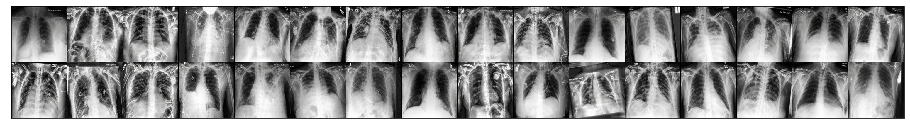

Trainable: 1, Frozen: 241


Score improved: 0.84169 > 0.00000
state dict saved to: save/models/dn121_AP_chkpnt.pt
Epoch [0] train_loss: 0.3914, train_auc: 0.8261, valid_loss: 0.3594, valid_auc: 0.8417


Score improved: 0.84229 > 0.84169
state dict saved to: save/models/dn121_AP_chkpnt.pt
Epoch [1] train_loss: 0.3858, train_auc: 0.8325, valid_loss: 0.3593, valid_auc: 0.8423


Score improved: 0.84341 > 0.84229
state dict saved to: save/models/dn121_AP_chkpnt.pt
Epoch [2] train_loss: 0.3848, train_auc: 0.8335, valid_loss: 0.3585, valid_auc: 0.8434


Score improved: 0.84359 > 0.84341
state dict saved to: save/models/dn121_AP_chkpnt.pt
Epoch [3] train_loss: 0.3843, train_auc: 0.8341, valid_loss: 0.3583, valid_auc: 0.8436


Score improved: 0.84376 > 0.84359
state dict saved to: save/models/dn121_AP_chkpnt.pt
Epoch [4] train_loss: 0.3839, train_auc: 0.8345, valid_loss: 0.3586, valid_auc: 0.8438

File saved to: save/histories/dn121_AP.pkl
state dict saved to: save/models/dn121_AP_e5.pt


In [137]:
train_loader, valid_loader = get_pdloaders(df_atrain, df_avalid, grp_id=1, seed=404)
#train_loader, valid_loader,test_loader = subset_dloader(df,1,it,seed=404,print_tfms=it) for df,it in zip(dfs_tvt,(True,False,False))
show_batch(train_loader,denorm=True)

savename=f'dn121_AP'
n_epochs = 5

trainer = make_trainer('densenet121', 1e-3)
hist = trainer.train(train_loader, valid_loader, n_epochs, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "AP projections only, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)
save_trained(trainer.model, savename+f'_e{n_epochs}', save_desc)

In [242]:
trainer = make_trainer('densenet121', 1e-3)
load_trained(trainer.model,'dn121_AP_chkpnt')
print('Full Test chkpnt - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
load_trained(trainer.model,'dn121_AP_e5')
print('Full Test 5 epoch - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
load_trained(trainer.model,'dn121_AP_chkpnt')
print('Group1 Test chkpnt - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader1)))

Trainable: 1, Frozen: 241


Full Test chkpnt - Loss: 0.52258, AUC: 0.76028


Full Test 5 epoch - Loss: 0.52662, AUC: 0.76080


Group1 Test chkpnt - Loss: 0.54308, AUC: 0.78020


### Group = PA(2)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

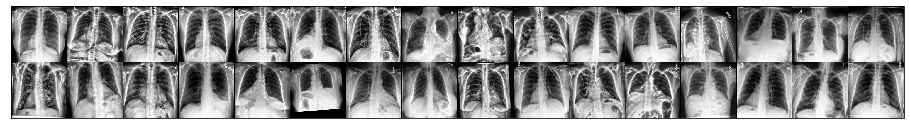

Trainable: 1, Frozen: 241


Score improved: 0.77618 > 0.00000
state dict saved to: save/models/dn121_PA_chkpnt.pt
Epoch [0] train_loss: 0.3769, train_auc: 0.7286, valid_loss: 0.3085, valid_auc: 0.7762


Score improved: 0.78051 > 0.77618
state dict saved to: save/models/dn121_PA_chkpnt.pt
Epoch [1] train_loss: 0.3619, train_auc: 0.7581, valid_loss: 0.3061, valid_auc: 0.7805


Score improved: 0.78199 > 0.78051
state dict saved to: save/models/dn121_PA_chkpnt.pt
Epoch [2] train_loss: 0.3578, train_auc: 0.7668, valid_loss: 0.3058, valid_auc: 0.7820


Score improved: 0.78394 > 0.78199
state dict saved to: save/models/dn121_PA_chkpnt.pt
Epoch [3] train_loss: 0.3554, train_auc: 0.7715, valid_loss: 0.3058, valid_auc: 0.7839


Epoch [4] train_loss: 0.3539, train_auc: 0.7746, valid_loss: 0.3069, valid_auc: 0.7805

File saved to: save/histories/dn121_PA.pkl
state dict saved to: save/models/dn121_PA_e5.pt


In [138]:
train_loader, valid_loader = get_pdloaders(df_atrain, df_avalid, grp_id=2, seed=404)
show_batch(train_loader,denorm=True)

savename=f'dn121_PA'
n_epochs = 5

trainer = make_trainer('densenet121', 1e-3)
hist = trainer.train(train_loader, valid_loader, n_epochs, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "PA projections only, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)
save_trained(trainer.model, savename+f'_e{n_epochs}', save_desc)

In [237]:
trainer = make_trainer('densenet121', 1e-3)
load_trained(trainer.model,'dn121_PA_chkpnt')
print('Full Test chkpnt - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
load_trained(trainer.model,'dn121_PA_e5')
print('Full Test 5 epoch - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
load_trained(trainer.model,'dn121_PA_chkpnt')
print('Group2 Test chkpnt - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader2)))

Trainable: 1, Frozen: 241


Full Test chkpnt - Loss: 0.57724, AUC: 0.67194


Full Test 5 epoch - Loss: 0.58133, AUC: 0.67173


### Group = LL(3)

==================== Augmentations ====================
RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.020000000000000018, 0.020000000000000018))
OneOf([
  TemplateCrop(always_apply=False, p=1.0, tm_method=5, init_resize=(256, 256)),
  Compose([
    Resize(always_apply=False, p=1.0, height=256, width=256, interpolation=1),
    RandomCrop(always_apply=False, p=1.0, height=244, width=244),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
IAAAffine(always_apply=False, p=0.5, scale=(1.0, 1.0), translate_percent=None, translate_px=None, rotate=(-0.0, 0.0), shear=(-5, 5), order=1, cval=0, mode='reflect')
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_v

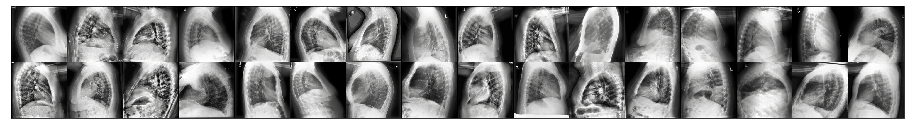

Trainable: 1, Frozen: 241


Score improved: 0.74795 > 0.00000
state dict saved to: save/models/dn121_LL_chkpnt.pt
Epoch [0] train_loss: 0.3847, train_auc: 0.7273, valid_loss: 0.3308, valid_auc: 0.7479


Score improved: 0.75674 > 0.74795
state dict saved to: save/models/dn121_LL_chkpnt.pt
Epoch [1] train_loss: 0.3703, train_auc: 0.7552, valid_loss: 0.3270, valid_auc: 0.7567


Score improved: 0.75739 > 0.75674
state dict saved to: save/models/dn121_LL_chkpnt.pt
Epoch [2] train_loss: 0.3665, train_auc: 0.7630, valid_loss: 0.3283, valid_auc: 0.7574


Epoch [3] train_loss: 0.3644, train_auc: 0.7671, valid_loss: 0.3283, valid_auc: 0.7570


Epoch [4] train_loss: 0.3630, train_auc: 0.7698, valid_loss: 0.3296, valid_auc: 0.7565

File saved to: save/histories/dn121_LL.pkl
state dict saved to: save/models/dn121_LL_e5.pt


In [139]:
train_loader, valid_loader = get_pdloaders(df_atrain, df_avalid, grp_id=3, seed=404)
show_batch(train_loader,denorm=True)

savename=f'dn121_LL'
n_epochs = 5

trainer = make_trainer('densenet121', 1e-3)
hist = trainer.train(train_loader, valid_loader, n_epochs, log_freq=10, save_name=f'{savename}_chkpnt')

save_desc = "LL projections only, samples {}, batch {}, lr {}, top val AUC {:0.5f}".format(
    len(train_loader.dataset), train_loader.batch_size, 
    trainer.optimizer.param_groups[0]['lr'], max(hist['valid_auc']))

save_history(hist, savename, save_desc)
save_trained(trainer.model, savename+f'_e{n_epochs}', save_desc)

In [243]:
trainer = make_trainer('densenet121', 1e-3)
load_trained(trainer.model,'dn121_LL_chkpnt')
print('Full Test chkpnt - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
load_trained(trainer.model,'dn121_LL_e5')
print('Full Test 5 epoch - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader_full)))
load_trained(trainer.model,'dn121_LL_chkpnt')
print('Group3 Test chkpnt - Loss: {:.5f}, AUC: {:.5f}'.format(*trainer.evaluate(test_loader3)))

Trainable: 1, Frozen: 241


Full Test chkpnt - Loss: 0.48778, AUC: 0.74004


Full Test 5 epoch - Loss: 0.51257, AUC: 0.73971


Group3 Test chkpnt - Loss: 0.31100, AUC: 0.72568


## Ensemble

In [30]:
@torch.no_grad()
def predict_loader(model, data_loader, sigmoid=True):
    was_training = model.training
    model.eval()
    preds = []
    for batch in tqdm(data_loader):
        data,target = to_device(batch, DEVICE)
        logits = model(data)
        pred = torch.sigmoid(logits) if sigmoid else logits
        preds.append(pred.detach())#.detach().to('cpu').numpy())
    model.train(was_training)
    return torch.vstack(preds).to('cpu').numpy()

In [31]:
def full_freeze(model):
    for p in filter(lambda x: hasattr(x,'weight'), model.parameters()):
        p.requires_grad_(False)

In [32]:
def ensemble(checkpoints,loader):
    ens_preds = []
    for mdlchk in checkpoints:
        trainer = make_trainer('densenet121', 1e-3)
        model = load_trained(trainer.model,mdlchk)
        full_freeze(model)
        preds = predict_loader(trainer.model, loader)
        ens_preds.append(preds)
    
    lab_preds = [*zip(loader.dataset.df.index,np.mean(ens_preds,0))]
        
    return pd.DataFrame([{'CheX_Image_ID':cid, **{k:v for k,v in zip(TARGET_LABELS,preds)}} for cid,preds in lab_preds])

In [33]:
df_ens = ensemble(['dn121_AP_chkpnt','dn121_PA_chkpnt','dn121_LL_chkpnt'],test_loader_full)
enspreds = df_ens.set_index('CheX_Image_ID').values
gtlabs = test_loader_full.dataset.df.drop('Path',1).values
roc_auc_score(gtlabs, enspreds, average='micro', multi_class='ovo')

Trainable: 1, Frozen: 241



Trainable: 1, Frozen: 241



Trainable: 1, Frozen: 241


0.7645696115012863

## Thresholding (DEPRECATED)

In [41]:
def linsearch_single(y_true, y_pred, start=0,end=1, num=1000):
    spac = np.linspace(start,end,num)
    tsco = [(t,roc_auc_score(y_true, (y_pred>=t).astype(int), average='micro', multi_class='ovo')) for t in spac]
    thrssco5 = sorted(tsco, key=lambda x: x[1], reverse=True)[:5]
    
    return thrssco5

def rand_search(y_true, y_pred, low=0,  high=1, nsearch=1000):
    spac = np.random.uniform(low,high, (nsearch,14)) #np.random.rand(nsearch,14)
    best_auc = 0
    best = np.full(14, 0.5)
    for i in tqdm(range(nsearch)):
        sco = roc_auc_score(y_true, (y_pred>=spac[i]).astype(int), average='micro', multi_class='ovo')
        if sco > best_auc:
            print(f'AUC Improve: {sco:.5f} > {best_auc:.5f}')
            best_auc = sco
            best = spac[i]
            print('Thresh:',best.round(2))
            
    return best

def linsearch_obo(y_true, y_pred, start=0, end=1, num=1000):
    spac = np.linspace(start,end,num)
    threshsp = np.full(14,0.5)
    
    best_threshs = np.zeros(14)
    for i in tqdm(range(len(threshsp))):
        try:
            best_sco = 0
            for t in spac:
                sco = roc_auc_score(y_true[:,i], (y_pred[:,i]>=t).astype(int), average='micro')#, multi_class='ovo')
                if sco > best_sco:
                    best_sco = sco
                    best_threshs[i] = t
            print(i,best_sco)
        except ValueError:
            best_threshs[i] = 0.5
    
    return best_threshs

In [50]:
linsearch_single(gtlabs, enspreds, 0.2, 0.3)

[(0.25265265265265263, 0.6925583699793141),
 (0.2527527527527528, 0.6925583699793141),
 (0.24584584584584585, 0.692551372019919),
 (0.24574574574574576, 0.6923579484222401),
 (0.25255255255255254, 0.6921715227839562)]

In [42]:
rand_search(gtlabs, enspreds, 0, 0.9, 100000)

AUC Improve: 0.62915 > 0.00000
Thresh: [0.38 0.84 0.08 0.01 0.72 0.23 0.9  0.78 0.43 0.06 0.56 0.86 0.8  0.47]
AUC Improve: 0.63772 > 0.62915
Thresh: [0.57 0.76 0.71 0.09 0.12 0.28 0.43 0.68 0.26 0.81 0.84 0.25 0.34 0.43]
AUC Improve: 0.64305 > 0.63772
Thresh: [0.63 0.28 0.85 0.29 0.69 0.86 0.21 0.39 0.08 0.05 0.04 0.21 0.36 0.46]
AUC Improve: 0.66307 > 0.64305
Thresh: [0.51 0.23 0.4  0.36 0.55 0.73 0.86 0.56 0.24 0.73 0.8  0.3  0.14 0.32]
AUC Improve: 0.74434 > 0.66307
Thresh: [0.34 0.   0.49 0.19 0.43 0.35 0.32 0.27 0.26 0.21 0.38 0.16 0.82 0.09]
AUC Improve: 0.75550 > 0.74434
Thresh: [0.39 0.03 0.29 0.26 0.62 0.13 0.76 0.67 0.28 0.18 0.39 0.35 0.5  0.24]
AUC Improve: 0.75736 > 0.75550
Thresh: [0.33 0.03 0.04 0.42 0.49 0.1  0.05 0.3  0.02 0.36 0.25 0.43 0.59 0.39]
AUC Improve: 0.76081 > 0.75736
Thresh: [0.28 0.06 0.05 0.06 0.9  0.04 0.22 0.45 0.25 0.37 0.28 0.88 0.4  0.13]
AUC Improve: 0.76238 > 0.76081
Thresh: [0.25 0.02 0.08 0.06 0.16 0.15 0.45 0.57 0.14 0.16 0.42 0.79 0.28 0.24]



array([0.24834693, 0.02224445, 0.07565832, 0.06349608, 0.16226645,
       0.14653204, 0.44576184, 0.56716256, 0.14179744, 0.15688471,
       0.41878654, 0.79479206, 0.28363954, 0.24189777])

In [53]:
rand_search(gtlabs, enspreds, 100000)

AUC Improve: 0.51119 > 0.00000
Thresh: [0.78 0.63 0.38 0.58 0.91 0.35 0.52 0.65 0.47 0.56 0.92 1.   0.17 0.85]
AUC Improve: 0.63072 > 0.51119
Thresh: [0.12 0.62 0.4  0.46 0.05 0.52 0.26 0.3  0.93 0.79 0.52 0.55 0.29 0.01]
AUC Improve: 0.69403 > 0.63072
Thresh: [0.31 0.16 0.03 0.39 0.9  0.26 0.85 0.3  0.26 0.14 0.71 0.77 0.86 0.22]
AUC Improve: 0.71722 > 0.69403
Thresh: [0.26 0.03 0.45 0.31 0.02 0.43 0.3  0.38 0.34 0.49 0.4  0.87 0.99 0.15]
AUC Improve: 0.72291 > 0.71722
Thresh: [0.92 0.04 0.99 0.1  0.8  0.63 0.13 0.79 0.1  0.54 0.5  0.15 0.35 0.17]
AUC Improve: 0.73768 > 0.72291
Thresh: [0.43 0.04 0.32 0.29 0.69 0.14 0.84 0.74 0.31 0.2  0.43 0.39 0.55 0.27]
AUC Improve: 0.74075 > 0.73768
Thresh: [0.62 0.02 0.77 0.14 0.97 0.15 0.53 0.95 0.17 0.12 0.2  0.14 0.51 0.22]
AUC Improve: 0.75892 > 0.74075
Thresh: [0.66 0.02 0.04 0.39 0.28 0.55 0.06 0.24 0.16 0.32 0.28 0.95 0.73 0.25]
AUC Improve: 0.75961 > 0.75892
Thresh: [0.16 0.02 0.76 0.22 0.7  0.13 0.43 0.85 0.05 0.69 0.36 0.18 0.39 0.3 ]



array([0.16391347, 0.02471843, 0.76331847, 0.22411597, 0.69772887,
       0.12995413, 0.42623702, 0.85326138, 0.05312146, 0.68797051,
       0.35664908, 0.17533143, 0.39045362, 0.29772767])

In [43]:
best_mthresh = np.array([0.16391347, 0.02471843, 0.76331847, 0.22411597, 0.69772887,
       0.12995413, 0.42623702, 0.85326138, 0.05312146, 0.68797051,
       0.35664908, 0.17533143, 0.39045362, 0.29772767])

best_mthresh2 = np.array([0.24834693, 0.02224445, 0.07565832, 0.06349608, 0.16226645,
       0.14653204, 0.44576184, 0.56716256, 0.14179744, 0.15688471,
       0.41878654, 0.79479206, 0.28363954, 0.24189777])

In [44]:
threshbest5 = np.array([roc_auc_score(gtlabs[:,i], enspreds[:,i]>best_mthresh2[i], average='micro', multi_class='ovo') for i in TARGET5_INDEX])
threshbest5

array([0.52597403, 0.60054926, 0.5       , 0.65555556, 0.72200375])

In [45]:
threshbest5

array([0.52597403, 0.60054926, 0.5       , 0.65555556, 0.72200375])

In [50]:
linsearch_obo(gtlabs,enspreds)

0 0.7208646616541353
1 0.6095412844036696
2 0.7189936215450035
3 0.7281746031746031
4 0.759656652360515
5 0.7428571428571429
6 0.6386250565355043
7 0.7024336283185841
8 0.6909902597402597
9 0.6664823008849557
10 0.7502904638484226
11 0.9163090128755365
13 0.6976230774891455



array([0.18318318, 0.04404404, 0.03903904, 0.45445445, 0.02102102,
       0.07307307, 0.08708709, 0.1031031 , 0.24724725, 0.03903904,
       0.38838839, 0.04204204, 0.5       , 0.35735736])

In [58]:

np.mean([0.791,
0.819,
0.738,
0.843,
0.850])



0.8081999999999999

In [51]:
linbest = _

In [52]:
lthreshbest5 = np.array([roc_auc_score(gtlabs[:,i], enspreds[:,i]>linbest[i], average='micro') for i in TARGET5_INDEX])

In [57]:
lthreshbest5.mean().round(4)

0.7084

In [54]:
roc_auc_score(gtlabs, enspreds>linbest, average='micro', multi_class='ovo') 

0.7510663490526162

In [39]:
threshbest5 = np.array([roc_auc_score(gtlabs[:,i], enspreds[:,i]>best_mthresh[i], average='micro', multi_class='ovo') for i in TARGET5_INDEX])

In [40]:
threshbest5

array([0.5       , 0.5       , 0.5       , 0.68677249, 0.72182501])

In [34]:
def pseudo_ensemble(checkpoints,loaders):
    psens_preds = []
    for mdlchk,loader in zip(checkpoints,loaders):
        trainer = make_trainer('densenet121', 1e-3)
        model = load_trained(trainer.model,mdlchk)
        full_freeze(model)
        preds = predict_loader(trainer.model,loader)
        psens_preds.extend([*zip(loader.dataset.df.index,preds)])
        
    return pd.DataFrame([{'CheX_Image_ID':cid, **{k:v for k,v in zip(TARGET_LABELS,preds)}} for cid,preds in psens_preds])

In [35]:
df_psens = pseudo_ensemble(['dn121_AP_chkpnt','dn121_PA_chkpnt','dn121_LL_chkpnt'],[test_loader1,test_loader2,test_loader3])
pspreds = df_psens.set_index('CheX_Image_ID').values
gtlabs = test_loader_full.dataset.df.drop('Path',1).values
roc_auc_score(gtlabs, pspreds, average='micro', multi_class='ovo')

Trainable: 1, Frozen: 241



Trainable: 1, Frozen: 241



Trainable: 1, Frozen: 241


0.6569012475962009

In [368]:
roc_auc_score(gtlabs,pspreds,average='micro',multi_class='ovr',labels=TARGET5_INDEX)

0.6685128216612036

In [410]:
t5idx = sorted(TARGET5_INDEX)
#gtlabs[:,TARGET5_INDEX]

In [411]:
roc_auc_score(gtlabs[:,t5idx],enspreds[:,t5idx],average='micro',multi_class='ovr')

0.5281112698035889

In [353]:
[gtlabs[:,i],pspreds[:,i]) for i in ]

[0.5063311688311689,
 0.5046952515946137,
 0.48243630333182574,
 0.5118165784832451,
 0.4536598444901242]

In [408]:
ens_auc = []
for i in range(len(gtlabs)):
    try:
        eauc = roc_auc_score(gtlabs[i],enspreds[i],multi_class='ovo')
        eauc5 = roc_auc_score(gtlabs[i,TARGET5_INDEX],enspreds[i,TARGET5_INDEX],multi_class='ovo')

        print(i,eauc,eauc5)
        ens_auc.append(eauc)
    except ValueError as e:
        print(i,'0000000000000000000000000000000000000000000000000000000000000000')
        pass

0 0.6363636363636362 0.25
1 0000000000000000000000000000000000000000000000000000000000000000
2 0000000000000000000000000000000000000000000000000000000000000000
3 0.6363636363636364 0.5
4 0000000000000000000000000000000000000000000000000000000000000000
5 0.8 1.0
6 0.6666666666666666 0.33333333333333337
7 0000000000000000000000000000000000000000000000000000000000000000
8 0000000000000000000000000000000000000000000000000000000000000000
9 0000000000000000000000000000000000000000000000000000000000000000
10 0.6734693877551021 0.5
11 0.5454545454545454 0.0
12 0000000000000000000000000000000000000000000000000000000000000000
13 0000000000000000000000000000000000000000000000000000000000000000
14 0000000000000000000000000000000000000000000000000000000000000000
15 0000000000000000000000000000000000000000000000000000000000000000
16 0.48484848484848486 0.0
17 0000000000000000000000000000000000000000000000000000000000000000
18 0.75 0.5
19 00000000000000000000000000000000000000000000000000000000000000

In [342]:
np.mean(ens_auc)

0.6525437736866307

In [303]:
df_psens.LabelProbs.str.split(',',expand=True)

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
229,NaN
230,NaN
231,NaN
232,NaN
